In [4]:
import urllib2
from bs4 import BeautifulSoup
import re
import nytimesarticle as nyta
import urllib2
import requests
import csv
import time
import pandas as pd
import numpy as np
import nytimes_crawl_2 as nytc
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

# Misc

## Analysis

### Scrape

In [8]:
reader = nytc.OpEdReader('one')
reader.save_oped_articles_all_pages(begindate='20160101',enddate='20160331')

In [ ]:
reader2 = nytc.OpEdReader('two')
reader2.save_oped_articles_all_pages(begindate='20161001',enddate='20160107')

In [ ]:
reader3 = nytc.OpEdReader('three')
reader3.save_oped_articles_all_pages(begindate='20150701',enddate='20151011')

### Load

In [9]:
reader = nytc.OpEdReader.init_from_file('one','one100.csv')

In [10]:
reader2 = nytc.OpEdReader.init_from_file('two','two100.csv')

In [11]:
reader3 = nytc.OpEdReader.init_from_file('three','three100.csv')

### Eliminate 'Universal' Articles

In [12]:
def elim_universal_wrapper(reader):
    print(reader.data.shape)
    reader.elim_universal()
    print(reader.data.shape)

In [13]:
elim_universal_wrapper(reader)
elim_universal_wrapper(reader2)
elim_universal_wrapper(reader3)

(947, 8)
(940, 8)
(952, 8)
(943, 8)
(959, 8)
(948, 8)


# Text Manipulation

In [14]:
import nltk

In [95]:
PUNCTUATION = """!@#$%^&*()_+=][{}'-";:/?\.,~`"""

def tidy_text(text):
    """ Does the following: 1. Tokenises words 2. Removes punctuation 3. Removes stop words 4. Puts words through the snowball stemmer"""

    stemmer = nltk.stem.snowball.EnglishStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english'))

    outwords = []
    for word in text.split():
        word = word.strip(PUNCTUATION).lower()
        if word not in stopwords:
            if len(word) > 0:
                if not word[0].isdigit():
                    outwords.append(stemmer.stem(word))

    return outwords


## Foreign Language

In [16]:
def locate_foreign(tidiedtext,reader):
    for idx, text in enumerate(tidiedtext):
        if 'de' in text and 'la' in text:
            print('Match')
            print(idx)
            print(text[:20])
            print(reader.data['url'].iloc[idx])

In [17]:
def possible_matches(reader):
    text = reader.data['full_text']
    tidiedtext = [tidy_text(item.decode('utf-8')) for item in text]
    locate_foreign(tidiedtext,reader)

### Drop Foreign Articles

In [18]:
def drop_rows_all(reader,indices):
    print(reader.data.shape)
    reader.drop_rows(indices)
    print(reader.data.shape)
    csvfilename = '{0}_english{1}.csv'.format(reader.name,100)
    reader.save_to_csv(csvfilename)

### Source #1

In [19]:
drop_rows_all(reader,[105,355,508,534])

(940, 8)
(936, 8)


### Source #2

In [20]:
drop_rows_all(reader2,[55,396,459,504,516,542,549])

(943, 8)
(936, 8)


### Source #3

In [21]:
drop_rows_all(reader3,[])

(948, 8)
(948, 8)


# Final Result

In [23]:
reader_english = nytc.OpEdReader.init_from_file('one_english','one_english100.csv')
reader2_english = nytc.OpEdReader.init_from_file('two_english','two_english100.csv')
reader3_english = nytc.OpEdReader.init_from_file('three_english','three_english100.csv')
readers_english = [reader3_english,reader2_english,reader_english]

## Tidy the Text, Join all Datasets

In [96]:
%%prun
dataall = pd.concat([reader.data for reader in readers_english])
text = dataall['full_text']
tidiedtext = [tidy_text(item.decode('utf-8')) for item in text]
tidiedtextjoined = [' '.join(text) for text in tidiedtext]

In [25]:
dataall = dataall.reset_index(drop=True)

## Distribution of 'Virality'

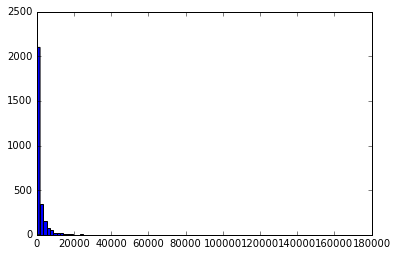

In [26]:
plt.hist(dataall['share_count'],bins=100)
plt.show()

# LDA

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [29]:
n_features = 1000
n_topics = 10
n_top_words = 20

In [30]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(tidiedtextjoined)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 1.468s.


In [32]:
print("Fitting LDA models with tf features and n_features=%d..."
      % (n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))


Fitting LDA models with tf features and n_features=1000...
done in 50.849s.


In [33]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
trump republican mr candid clinton polit parti democrat voter campaign presid sander would cruz like elect it one vote obama
Topic #1:
state unit north nuclear american islam iran war govern secur syria militari obama attack weapon israel must nation would could
Topic #2:
gun peopl drug polic patient death health mani crime kill year like medic use state violenc doctor one new would
Topic #3:
mr polit countri govern european nation parti union europ refuge year presid state would leader elect war minist right peopl
Topic #4:
mr govern feder public said state year congress new land offic investig report bill depart offici use power law charg
Topic #5:
one it like time peopl said get year know go us way day would even make want work think say
Topic #6:
school percent state new year tax student citi would educ program work incom worker pay health plan cost hous public
Topic #7:
women percent muslim religi social peopl men cultur sex live india american grou

In [34]:
doc_topic_distrib = lda.transform(tf)

In [35]:
doc_topic_distrib /= doc_topic_distrib.sum(axis=1)[:, np.newaxis]

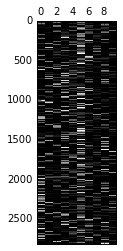

In [36]:
fig = plt.figure(1)
ax = fig.gca()
ax = ax.matshow(doc_topic_distrib, cmap=plt.cm.gray, aspect = '0.01')
plt.show()

In [38]:
def add_topic_weights(dataall,n_topics):
    for topicnum in range(n_topics):
        topicname = 'topic{0}'.format(topicnum)
        dataall[topicname] = doc_topic_distrib[:,topicnum]
    return dataall

In [39]:
dataallnew = add_topic_weights(dataall,n_topics)

# Extra Features

## Article Length

In [154]:
articlelens = []
for articletext in dataallnew['full_text']:
    articlelens.append(len(articletext.split()))
articlelensold = np.array(articlelens)
articlelens = articlelensold.astype('float64') - np.mean(articlelensold)
articlelens /= np.std(articlelens)

In [156]:
dataallnew['len'] = articlelens

# Machine Learning

In [48]:
from sklearn import linear_model, neighbors

In [157]:
featurenames = ['topic{0}'.format(i) for i in range(n_topics)] + ['len']
features = dataallnew[featurenames]
viralityname = 'comment_count'
virality = dataallnew[viralityname]

In [116]:
def split_data(data,frac=0.7):
    datanew = data.sample(frac=1)
    nrows = len(datanew)
    idx = int(nrows*frac)
    return {'train': data.iloc[:idx], 'test': data.iloc[idx:]}
    # use 70-30 split

In [117]:
def model_error(actual,predicted):
    nobs = actual.size
    return np.sqrt(1.0/(2.0*nobs)*np.sum((actual - predicted)**2))

In [138]:
def train_model(split_data,model,**kwargs):
    datatrain = split_data['train']
    datatest = split_data['test']
    model.fit(datatrain[featurenames],datatrain[viralityname],**kwargs)
    train_pred = model.predict(datatrain[featurenames])
    test_pred = model.predict(datatest[featurenames])
    train_error = model_error(train_pred,datatrain[viralityname])
    test_error = model_error(test_pred,datatest[viralityname])
    print('Training error: {0}'.format(train_error))
    print('Test error: {0}'.format(test_error))

In [162]:
datasplit = split_data(dataallnew)

## Scikit

### Linear Regression

In [163]:
model = linear_model.LinearRegression()

In [164]:
train_model(datasplit,model)

Training error: 4589.11027841
Test error: 4898.84394327


In [165]:
model = neighbors.KNeighborsRegressor(n_neighbors=10)

In [166]:
train_model(datasplit,model)

Training error: 4314.10122155
Test error: 5052.01120974


### K-Nearest Neighbors

In [122]:
np.mean(dataallnew[viralityname])

1827.3535460992907

In [168]:
for i in range(1,20):
    model = neighbors.KNeighborsRegressor(n_neighbors=i)
    train_model(datasplit,model)

Training error: 0.0
Test error: 7360.24258044
Training error: 2874.65785749
Test error: 5801.01059099
Training error: 3427.90644003
Test error: 5414.98694428
Training error: 3856.06985026
Test error: 5234.80246212
Training error: 4061.1112336
Test error: 5201.19709685
Training error: 4142.93223418
Test error: 5178.99388793
Training error: 4203.92486405
Test error: 5113.82750509
Training error: 4262.52938694
Test error: 5051.93066043
Training error: 4294.70745449
Test error: 5068.96680937
Training error: 4314.10122155
Test error: 5052.01120974
Training error: 4352.0417014
Test error: 5031.9918017
Training error: 4378.67053391
Test error: 5019.30719749
Training error: 4398.47348901
Test error: 5014.47379167
Training error: 4406.89225104
Test error: 5003.43165022
Training error: 4415.34336677
Test error: 4997.58552351
Training error: 4424.84022527
Test error: 4992.31574694
Training error: 4441.15604907
Test error: 4992.81375029
Training error: 4458.13132655
Test error: 5002.76875245
Train